###  <font color=#00b3e5> Import all the required Python Libraries

In [ ]:
import warnings
#Enable graph plotting in Jupyter
%matplotlib inline
# Numerical libraries
import numpy as np  
# to handle data in form of rows and columns 
import pandas as pd    
from pandas.tseries.offsets import DateOffset
from math import sqrt
from pandas import read_csv
from pandas import datetime
import datetime

import seaborn as sns
sns.set(color_codes=True)
sns.set_style("whitegrid")
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot


import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import adfuller

###  <font color=#00b3e5> Read the data
#### Data Source: https://www.kaggle.com/sudalairajkumar/covid19-in-india
#### The data comprises of recorded number of confirmed, cured and death cases across various states of India, in a time series fashion. The repository has two CSV files: “covid_19_india.csv” has record entries from Apr, 2020 till Oct, 2020, for each date within the time period & the other file “StatewiseTestingDetails.csv” have state wise/Union Territory wise distribution of total samples tested along with corresponding positive/negatives cases confirmed for each date entry

In [156]:
data1=pd.read_csv('covid_19_india.csv',engine='python',sep=',')
data2=pd.read_csv('StatewiseTestingDetails.csv',engine='python',sep=',')

#### Replacing all occurences of Telangana followed by special characters with one unique entry for the state value 'Telangana'

In [157]:
data1.rename(columns = {'State/UnionTerritory':'State'}, inplace = True) 
data1['State'] = data1['State'].map(lambda x: x.rstrip('***'))
data1.replace(to_replace =["Telengana"],value ="Telangana",inplace=True) 
data1['State'].unique()

array(['Kerala', 'Telangana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
       'Tripura', 'Nagaland', 'Meghalaya', 'Dadar Nagar Haveli',
       'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
       'Dadra and Nagar Haveli and Daman and Diu'], dtype=object)

####   Converting the Date format into YYYY-MM-DD in order to merge both the datasets based on date value. 
####   Also, since after the initial one month of the outbreak, the international boundaries were closed, hence most of the entries for ConfirmedForeignNational is NaN and ConfirmedIndianNational is 1, hence dropping these two fields. Additionally these will not be used for our Univariate Time series Model. 

In [158]:
data2['Date_new'] = pd.to_datetime(data2.Date)
data2['Date'] = data2['Date_new'].dt.strftime("%d/%m/%y")
data = data1.merge(data2, on=['Date','State'])
data.drop(['ï»¿Sno','ConfirmedIndianNational','ConfirmedForeignNational','Date','Time'],axis=1,inplace=True)
data=data.sort_values(by=['State','Date_new'])
data.head(10)

,State,Cured,Deaths,Confirmed,TotalSamples,Negative,Positive,Date_new
244,Andaman and Nicobar Islands,10,0,11,1403.0,1210,12.0,2020-04-17
438,Andaman and Nicobar Islands,11,0,22,2679.0,NaN,27.0,2020-04-24
515,Andaman and Nicobar Islands,11,0,33,2848.0,NaN,33.0,2020-04-27
626,Andaman and Nicobar Islands,16,0,33,3754.0,NaN,33.0,2020-05-01
1040,Andaman and Nicobar Islands,33,0,33,6677.0,NaN,33.0,2020-05-16
1126,Andaman and Nicobar Islands,33,0,33,6965.0,NaN,33.0,2020-05-19
1156,Andaman and Nicobar Islands,33,0,33,7082.0,NaN,33.0,2020-05-20
1184,Andaman and Nicobar Islands,33,0,33,7167.0,NaN,33.0,2020-05-21
1213,Andaman and Nicobar Islands,33,0,33,7263.0,NaN,33.0,2020-05-22
1244,Andaman and Nicobar Islands,33,0,33,7327.0,NaN,33.0,2020-05-23


### <font color=#00b3e5> Write a function that will calulate the Daywise values from the cumulative values in the columns

In [159]:
def calculate_daywise_value(col_name):
    data['Daywise_'+ col_name]=''
    for i in data['State'].unique():
        data['Daywise_'+ col_name]=np.where((data['State']==i) ,data[col_name]-data[col_name].shift(1),data['Daywise_'+ col_name])
    data['Daywise_'+ col_name] = data['Daywise_'+ col_name].astype(float)
    data['Daywise_'+ col_name]=np.where(data['Daywise_'+ col_name]<0,0,data['Daywise_'+ col_name])
    data['Daywise_'+ col_name].fillna(0,inplace=True)

#data[data['State']=='Kerala']

###  <font color=#00b3e5> Calculate Daywise Values

In [160]:
calculate_daywise_value('Confirmed')
calculate_daywise_value('Deaths')
calculate_daywise_value('Cured')
data.head()

,State,Cured,Deaths,Confirmed,TotalSamples,Negative,Positive,Date_new,Daywise_Confirmed,Daywise_Deaths,Daywise_Cured
244,Andaman and Nicobar Islands,10,0,11,1403.0,1210,12.0,2020-04-17,0.0,0.0,0.0
438,Andaman and Nicobar Islands,11,0,22,2679.0,NaN,27.0,2020-04-24,11.0,0.0,1.0
515,Andaman and Nicobar Islands,11,0,33,2848.0,NaN,33.0,2020-04-27,11.0,0.0,0.0
626,Andaman and Nicobar Islands,16,0,33,3754.0,NaN,33.0,2020-05-01,0.0,0.0,5.0
1040,Andaman and Nicobar Islands,33,0,33,6677.0,NaN,33.0,2020-05-16,0.0,0.0,17.0


###  <font color=#00b3e5> To build a Time series model on Confirmed cases forecasting, we take our first subset

In [161]:
data['Date'] = data['Date_new'].dt.strftime("%d/%m/%y")

In [162]:
data_subset=data[['Date_new','State','Daywise_Confirmed']]
data_subset

,Date_new,State,Daywise_Confirmed
244,2020-04-17,Andaman and Nicobar Islands,0.0
438,2020-04-24,Andaman and Nicobar Islands,11.0
515,2020-04-27,Andaman and Nicobar Islands,11.0
626,2020-05-01,Andaman and Nicobar Islands,0.0
1040,2020-05-16,Andaman and Nicobar Islands,0.0
...,...,...,...
6409,2020-10-22,West Bengal,4069.0
6443,2020-10-23,West Bengal,4157.0
6476,2020-10-24,West Bengal,4143.0
6509,2020-10-25,West Bengal,4148.0


In [169]:
data_subset[data_subset['Date_new']=='2020-04-04']

,Date_new,State,Daywise_Confirmed
16,2020-04-04,Kerala,9.0
17,2020-04-04,West Bengal,32.0


###  <font color=#00b3e5> Caluclate the Nation Wise Total Day wise confirmed cases reported 

In [165]:
data_subset_india=data_subset.groupby('Date_new').sum()
data_subset_india

,Daywise_Confirmed
Date_new,
2020-04-01,0.0
2020-04-02,24.0
2020-04-03,21.0
2020-04-04,41.0
2020-04-05,11.0
...,...
2020-10-23,55578.0
2020-10-24,53282.0
2020-10-25,50043.0


###  <font color=#00b3e5> Plot the Day wise Confirmed Cases over the time period of one year (y. 2020)

            Daywise_Confirmed
Date_new                     
2020-04-01                0.0
2020-04-02               24.0
2020-04-03               21.0
2020-04-04               41.0
2020-04-05               11.0


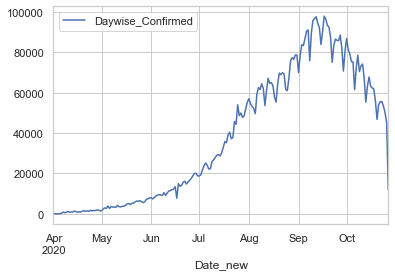

In [170]:
print(data_subset_india.head())
data_subset_india.plot()
pyplot.show()

###  <font color=#00b3e5> Plotting Autocorrelation graph

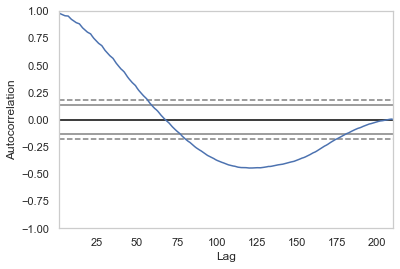

In [173]:
autocorrelation_plot(data_subset_india['Daywise_Confirmed'])
pyplot.show()

In [ ]:
#pip install statsmodels 

###  <font color=#00b3e5> Augmented Dickey Fuller Test to check if the given data is stationary and thereby determining the value of derivative order to be used in the ARIMA Model
#### Ho: It is non-stationary ; H1: It is stationary

In [174]:
def adfuller_test(df):
    result=adfuller(df)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis,indicating it is non-stationary ")

In [175]:
adfuller_test(data_subset_india['Daywise_Confirmed'])

ADF Test Statistic : -2.0311134408215654
p-value : 0.2730997215845634
#Lags Used : 15
Number of Observations : 194
Weak evidence against null hypothesis,indicating it is non-stationary 


###  <font color=#00b3e5> Calculate First Order differentiation

In [176]:
data_subset_india['Daywise_Confirmed_1st_diff']=data_subset_india['Daywise_Confirmed']-data_subset_india['Daywise_Confirmed'].shift(1)

In [178]:
adfuller_test(data_subset_india['Daywise_Confirmed_1st_diff'].dropna())

ADF Test Statistic : 1.295909338398465
p-value : 0.9965859335614593
#Lags Used : 15
Number of Observations : 193
Weak evidence against null hypothesis,indicating it is non-stationary 


###  <font color=#00b3e5> Calculate Second Order differentiation

In [179]:
data_subset_india['Daywise_Confirmed_2nddiff']=data_subset_india['Daywise_Confirmed_1st_diff']-data_subset_india['Daywise_Confirmed_1st_diff'].shift(1)
adfuller_test(data_subset_india['Daywise_Confirmed_2nddiff'].dropna())

ADF Test Statistic : -3.238241740967232
p-value : 0.017875100613437632
#Lags Used : 15
Number of Observations : 192
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


####  Removing the calculated derivatives; Conclusion: d=2 yields in stationary data

In [180]:
#The hyper-parameter “d” determines the order of derivative.
data_subset_india.drop(['Daywise_Confirmed_1st_diff', 'Daywise_Confirmed_2nddiff'],axis=1,inplace=True)

###  <font color=#00b3e5> Define Grid search ARIMA parameters for time series

In [182]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

###  <font color=#00b3e5>  Evaluate the different values of Grid Search

In [191]:
evaluate_models(data_subset1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=47559.055
ARIMA(0, 0, 1) RMSE=25229.327
ARIMA(0, 1, 0) RMSE=7349.137
ARIMA(0, 1, 1) RMSE=7564.493
ARIMA(0, 1, 2) RMSE=7233.294
ARIMA(0, 2, 0) RMSE=9574.034
ARIMA(0, 2, 1) RMSE=7368.912
ARIMA(1, 0, 0) RMSE=7290.706
ARIMA(1, 1, 0) RMSE=7463.158
ARIMA(1, 1, 1) RMSE=7400.199
ARIMA(1, 1, 2) RMSE=7258.165
ARIMA(1, 2, 0) RMSE=9175.352
ARIMA(2, 0, 0) RMSE=7406.344
ARIMA(2, 1, 0) RMSE=7257.420
ARIMA(2, 1, 1) RMSE=7301.312
ARIMA(2, 2, 0) RMSE=8145.303
ARIMA(4, 0, 0) RMSE=7429.414
ARIMA(4, 1, 0) RMSE=7326.434
ARIMA(4, 1, 1) RMSE=7269.850
ARIMA(4, 2, 0) RMSE=8045.782
ARIMA(6, 0, 0) RMSE=6915.682
ARIMA(6, 1, 0) RMSE=7129.898
ARIMA(6, 1, 1) RMSE=6510.764
ARIMA(6, 2, 0) RMSE=5353.188
Best ARIMA(6, 2, 0) RMSE=5353.188


###  <font color=#00b3e5> Build the ARIMA Model with Order : p=6, d=2, q=0

                              ARIMA Model Results                               
Dep. Variable:     D2.Daywise_Confirmed   No. Observations:                  208
Model:                   ARIMA(6, 2, 0)   Log Likelihood               -1983.689
Method:                         css-mle   S.D. of innovations           3292.233
Date:                  Sun, 17 Jan 2021   AIC                           3983.378
Time:                          15:02:00   BIC                           4010.079
Sample:                      04-03-2020   HQIC                          3994.174
                           - 10-27-2020                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -27.5034     34.984     -0.786      0.433     -96.070      41.064
ar.L1.D2.Daywise_Confirmed    -1.0270      0.051    -20.027      0.

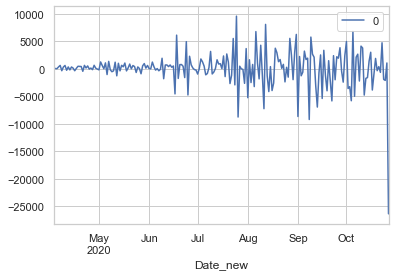

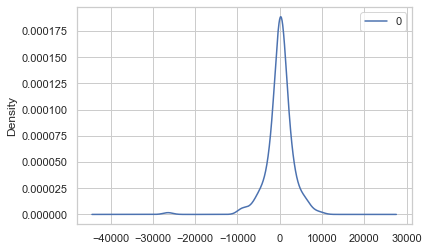

                  0
count    208.000000
mean       2.844267
std     3300.483117
min   -26395.694114
25%     -946.662745
50%      146.803801
75%     1225.445100
max     9578.794896


In [188]:
# fit model
model = ARIMA(data_subset_india, order=(6,2,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

###  <font color=#00b3e5> Evaluate Forecast

In [203]:
#data_subset1.index = data_subset1.index.to_period('M')
# split into train and test sets
X = data_subset_india.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(6,2,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts

predicted=56128.621138, expected=57720.000000
predicted=58324.606655, expected=55340.000000
predicted=63581.521919, expected=64531.000000
predicted=63620.557818, expected=69652.000000
predicted=68037.668320, expected=68898.000000
predicted=70322.048509, expected=69878.000000
predicted=64586.322252, expected=69101.000000
predicted=63459.909947, expected=61546.000000
predicted=66359.913055, expected=60975.000000
predicted=68942.134550, expected=67151.000000
predicted=68056.207525, expected=75749.000000
predicted=75699.580994, expected=77277.000000
predicted=79401.523771, expected=76472.000000
predicted=72139.165907, expected=78655.000000
predicted=72449.754630, expected=78618.000000
predicted=80797.833694, expected=69921.000000
predicted=78171.051455, expected=78357.000000
predicted=82830.884345, expected=83706.000000
predicted=83335.507374, expected=83291.000000
predicted=85105.557686, expected=86659.000000
predicted=88899.580492, expected=90389.000000
predicted=85821.554108, expected=9

###  <font color=#00b3e5> Calculate Mean Absoluate Error and RMSE

Test MAE: 3725.034
Test RMSE: 5353.188


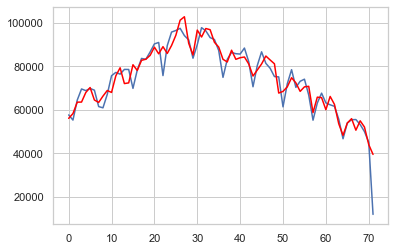

In [204]:
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

###  <font color=#00b3e5> Forecast and Plot Day Wise Confirmed Cases for the next one month

In [346]:
data_subset2=data_subset_india.reset_index()

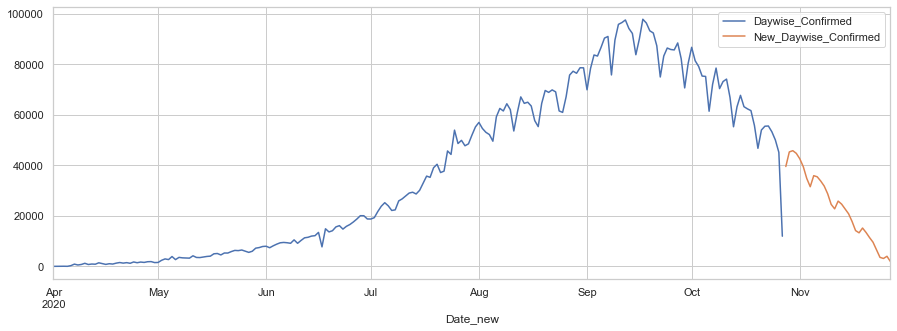

In [341]:

forecast = model_fit.predict(start = len(data_subset_india), end = (len(data_subset_india)-1) +  30, typ = 'levels') 
forecast=pd.DataFrame(forecast,columns=['New_Daywise_Confirmed'])
forecast['Date_new']=pd.date_range(start='2020-10-28', periods=31, freq='D')
forecast=forecast[['Date_new','New_Daywise_Confirmed']]
predicted_df=pd.concat([data_subset2,forecast])
predicted_df.set_index('Date_new',inplace=True)
predicted_df[['Daywise_Confirmed','New_Daywise_Confirmed']].plot(figsize = (15, 5), legend = True) 
#forecast.plot(legend = True) 